
<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Ophys</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">August, 2021</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>Here we build on the classification tutorial to apply these same concepts to real neural data

</div>


# Apply classification (decoding) to neural data
The previous classification tutorial applied classification on low-dimensional (2D or 3D) datasets. We will now extend this concept to actual (higher dimensional) neural data from the Visual Behavior dataset. 

In the example below, we will attempt to classify the neural response based on the stimulus that elicited that response. This is a form of 'decoding'. In other words, we will attempt to decode the stimulus based only on the neural response.

In the following example, the number of feature dimensions will be much higher. We will use the average response of each simultaneously recorded neuron in a short window following the stimulus as our feature matrix. Thus, our number of features will be equal to the number of simultaneously recorded neurons.

It's important to note that the choice of which feature to use is a design choice on the part of the scientist. Instead of using the average response, we could make many other choices such as using the max response, the instantaneous response at some point in time, or even maintaining the full dynamic timecourse (though this latter choice would dramatically increase our dimensionality).

## first some imports

In [2]:
# os is a library of standard operating system functions
import os

# numpy is a library of mathematical functions for manipulating arrays
import numpy as np

# pandas is a library of data analysis tools
import pandas as pd

# matplotlib is a plotting library
import matplotlib.pyplot as plt

# seaborn is a library of plotting functions built on top of matplotlib
import seaborn as sns

# The allensdk is the institute toolset of interacting with data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

# mindscope_utilities contains convenience functions built on top of the AllenSDK
import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

# This sets the number of columns that will be displayed by default when viewing Pandas tables
pd.set_option('display.max_columns', 500)

In [4]:
import platform
platstring = platform.platform()

if ('amzn1' in platstring):
    # for AWS
    data_storage_directory = "/data/visual-behavior-ophys-data"
    # use local cache for AWS
    cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_storage_directory, use_static_cache=True)
else:  
    # for local drive, different operating systems
    if 'Darwin' in platstring:
        # OS X 
        data_root = "/Volumes/Brain2021/"
    elif 'Windows'  in platstring:
        # Windows (replace with the drive letter of USB drive)
        data_root = "E:/"
        #data_root = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache'
    else:
        # your own linux platform
        # EDIT location where you mounted hard drive
        data_root = "/media/$USERNAME/Brain2021/"
        data_root = "/run/media/tom.chartrand/Brain2021"
        
    # visual behavior cache directory
    cache_dir = manifest_path = os.path.join(data_root, "visual_behavior")
    # use from_s3_cache for loading from local directory
    cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)

ophys_session_table.csv: 100%|█████████████████████████████████████████████████████| 227k/227k [00:00<00:00, 1.89MMB/s]
behavior_session_table.csv: 100%|████████████████████████████████████████████████| 1.21M/1.21M [00:00<00:00, 4.74MMB/s]
ophys_experiment_table.csv: 100%|██████████████████████████████████████████████████| 610k/610k [00:00<00:00, 3.44MMB/s]
ophys_cells_table.csv: 100%|█████████████████████████████████████████████████████| 4.29M/4.29M [00:00<00:00, 5.40MMB/s]


## Next we need to get some data loaded

### Set up data paths, load session/experiment table
Recall from the Visual Behavior data overview that we have hundreds of behavior/ophys sessions, each with up to 8 simultaneously acquired imaging planes (aka 'experiments')

In [5]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)

In [6]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

### Load one example session
We are going to select one session from the session table, session 990139534. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in somatostatin positive inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session. 
We can view metadata for this session as follows:

In [26]:
ophys_session_id = 854060305
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      440631
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                M
age_in_days                                                                      129
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                     6
prior_exposures_to_session_type                                                    0
prior_exposures_to_image_set                                     

In [27]:
# Note the difference in selection:
print(type(session_table.loc[ophys_session_id])) # single brackets 
print(type(session_table.loc[[ophys_session_id]])) # double brackets

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


### Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments (this session has 6) associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [8]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_854759890.nwb: 100%|█████████████████████████████████████| 233M/233M [00:34<00:00, 6.67MMB/s]
behavior_ophys_experiment_854759894.nwb: 100%|█████████████████████████████████████| 255M/255M [00:38<00:00, 6.67MMB/s]
behavior_ophys_experiment_854759896.nwb: 100%|█████████████████████████████████████| 240M/240M [00:34<00:00, 6.87MMB/s]
behavior_ophys_experiment_854759898.nwb: 100%|█████████████████████████████████████| 259M/259M [00:44<00:00, 5.80MMB/s]
behavior_ophys_experiment_854759900.nwb: 100%|█████████████████████████████████████| 242M/242M [00:38<00:00, 6.31MMB/s]
behavior_ophys_experiment_854759903.nwb: 100%|█████████████████████████████████████| 254M/254M [00:37<00:00, 6.69MMB/s]


## Restructure neural data

The cell below will load the neural data into a pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `visual_behavior_ophys` module of the `mindscope_utilities` package that was imported above as `ophys`. 

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

Also note that this could fail if you are on a machine or cloud instance with too little available RAM.

In [17]:
# you can also use tqdm package to display progress bar.
# EXAMPLE:
# _________
# from tqdm import tqdm
# for i in tqdm(I):


In [16]:
# create an empty list
neural_data = []
for ii, ophys_experiment_id in enumerate(experiments.keys()): 
    print('on experiment {} of {}'.format(ii+1, len(experiments)), end='\r')
    this_experiment = experiments[ophys_experiment_id]
    
    # append the data for this experiment to a list
    neural_data.append(ophys.build_tidy_cell_df(this_experiment))
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

In [20]:
neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id
0,10.52216,0.400583,0.0,0.0,1080852071,1086550481
1,10.61538,0.126125,0.0,0.0,1080852071,1086550481
2,10.70860,-0.083087,0.0,0.0,1080852071,1086550481
3,10.80182,0.158960,0.0,0.0,1080852071,1086550481
4,10.89504,0.301507,0.0,0.0,1080852071,1086550481


In [19]:
len(neural_data)

2561543

This dataframe is over 2 million rows long

In [21]:
len(neural_data['cell_specimen_id'].unique())

53

And it contains the timeseries of 53 unique simultaneously recorded neurons

## Set up data for a classification algorithm and scikit-learn
We need to get the data into a standard format for the classification algorithms in scikit learn, which is often a feature matrix (**`X`**) and a vector of labels (**`y`**).

For this analysis, let's look at the responses to each of the **8 unique visual stimuli** in this session, plus the response to **omitted** stimuli.

### make some decisions about the format of `X`
Our goal is to construct a feature matrix that consists of the the average response of each cell in a short (750ms) window following each stimulus on every stimulus presentation. Each stimulus_presentation will be represented by an `n_neurons` dimension feature vector. Our feature matrix, `X`, will thus be `n_trials x n_neurons`

But as noted in the introduction, we could have made many other choices about the format of `X`. An interesting exercise would be to repeat the analyses that follow with different choices for the feature matrix `X`.

### Calculate the full response to each stimulus
First, we will calculate an event triggered response to each stimulus start time in the stimulus table.

To start with, let's define a simple wrapper function on the `mindscope_utilities.event_triggered_response` function. We are going to use the deltaF/F response in a window from 0 to 750 ms from every stimulus event to calculate the response:

In [29]:
def calculate_event_triggered_response(single_cell_data, event_times):
    event_triggered_response = mindscope_utilities.event_triggered_response(
        single_cell_data,
        t = 'timestamps',
        y = 'dff',
        event_times = event_times,
        t_before = 0,
        t_after = 0.75,
        output_sampling_rate = 30 
    )
    
    return event_triggered_response

We are going to define our 'event_times' as the start time of *every* unique stimulus. First we will load the stimulus table from one of our experiments. Recall that each experiment in a given session shares the same stimulus data:

In [37]:
stimulus_presentations = experiments[ophys_experiment_ids[0]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
stimulus_presentations.head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25021,18001.0,0,im000,0,False,17986,310.55053,310.80074,False
1,0.25020,18046.0,0,im000,1,False,18031,311.30115,311.55135,False
2,0.25021,18091.0,0,im000,2,False,18076,312.05179,312.30200,False
3,0.25020,18136.0,0,im000,3,False,18121,312.80242,313.05262,False
4,0.25021,18181.0,0,im000,4,False,18166,313.55303,313.80324,False
5,0.25023,18226.0,0,im000,5,False,18211,314.30362,314.55385,False
6,0.25020,18271.0,0,im000,6,False,18256,315.05426,315.30446,False
7,0.25020,18316.0,0,im000,7,False,18301,315.80487,316.05507,False
8,0.25022,18361.0,0,im000,8,False,18346,316.55547,316.80569,False


Then we will select our event times as the `start_time` of each stimulus

In [31]:
event_times = stimulus_presentations['start_time']

Now iterate over every cell and apply the above function to build out an event triggered response for every cell/stimulus

In [32]:
# instantiate an empty list. We will append every event triggered response to this list
full_etr = []

# iterate over each unique cell
cell_specimen_ids = neural_data['cell_specimen_id'].unique()

for cell_count, cell_specimen_id in enumerate(cell_specimen_ids):
    print('on cell {}, #{} of {}'.format(cell_specimen_id, cell_count+1, len(cell_specimen_ids)), end='\r')
    
    # calculate the event triggered response for this cell
    full_etr_this_cell = calculate_event_triggered_response(
        neural_data.query('cell_specimen_id == @cell_specimen_id'),
        event_times
    )
    
    # add a column identifying the cell_specimen_id
    full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
    # append to our list
    full_etr.append(full_etr_this_cell)
    
# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr)

The resulting dataframe includes the full response of every cell to every stimulus event on a common 30 Hz timebase. We can view it as follows.

In [33]:
full_etr

,time,dff,event_number,event_time,cell_specimen_id
0,0.000000,0.023087,0,310.55053,1086550481
1,0.033333,0.023667,0,310.55053,1086550481
2,0.066667,0.040734,0,310.55053,1086550481
3,0.100000,0.057801,0,310.55053,1086550481
4,0.133333,0.060548,0,310.55053,1086550481
...,...,...,...,...,...
110487,0.600000,-0.030149,4803,3916.56159,1086551209
110488,0.633333,-0.027037,4803,3916.56159,1086551209
110489,0.666667,-0.017475,4803,3916.56159,1086551209
110490,0.700000,-0.007914,4803,3916.56159,1086551209


But as noted above, what we're interested in is just the *average* response of each cell to each stimulus. We can use the Pandas `groupby` command to group by `cell_specimen_id` and `event_number`

In [34]:
average_responses = full_etr.groupby(
    ['cell_specimen_id','event_number']
)[['dff']].mean().reset_index()
average_responses

,cell_specimen_id,event_number,dff
0,1086547630,0,-0.272757
1,1086547630,1,0.329051
2,1086547630,2,0.346391
3,1086547630,3,0.133382
4,1086547630,4,-0.039011
...,...,...,...
254607,1086560061,4799,-0.008919
254608,1086560061,4800,-0.015035
254609,1086560061,4801,0.012123
254610,1086560061,4802,-0.024956


The `event_triggered_response` function returns a column called `event_number`. Because we passed in every event in the stimulus table, this number will correspond directly with the `stimulus_presentations_id` column in the stimulus table (see above). We will rename it for clarity and to facilitate merges below:

In [35]:
average_responses.rename(columns={'event_number':'stimulus_presentations_id'}, inplace=True)
average_responses

,cell_specimen_id,stimulus_presentations_id,dff
0,1086547630,0,-0.272757
1,1086547630,1,0.329051
2,1086547630,2,0.346391
3,1086547630,3,0.133382
4,1086547630,4,-0.039011
...,...,...,...
254607,1086560061,4799,-0.008919
254608,1086560061,4800,-0.015035
254609,1086560061,4801,0.012123
254610,1086560061,4802,-0.024956


Then we can easily merge in stimulus information from the stimulus table by merging on the `stimulus_presentations_id` column:

In [36]:
average_responses = average_responses.merge(
    stimulus_presentations,
    on = 'stimulus_presentations_id',
    how = 'left'
)
average_responses

,cell_specimen_id,stimulus_presentations_id,dff,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
0,1086547630,0,-0.272757,0.25021,18001.0,0,im000,0,False,17986,310.55053,310.80074,False
1,1086547630,1,0.329051,0.25020,18046.0,0,im000,1,False,18031,311.30115,311.55135,False
2,1086547630,2,0.346391,0.25021,18091.0,0,im000,2,False,18076,312.05179,312.30200,False
3,1086547630,3,0.133382,0.25020,18136.0,0,im000,3,False,18121,312.80242,313.05262,False
4,1086547630,4,-0.039011,0.25021,18181.0,0,im000,4,False,18166,313.55303,313.80324,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254607,1086560061,4799,-0.008919,0.25019,234005.0,4,im045,4614,False,233990,3913.55912,3913.80931,False
254608,1086560061,4800,-0.015035,0.25024,234050.0,4,im045,4615,False,234035,3914.30972,3914.55996,False
254609,1086560061,4801,0.012123,0.25020,234095.0,4,im045,4616,False,234080,3915.06037,3915.31057,False
254610,1086560061,4802,-0.024956,0.25020,234140.0,4,im045,4617,False,234125,3915.81098,3916.06118,False


Now we can construct a dataframe called `features_and_labels` that will contain one row per trial, one column per cell, plus columns with the image_index and image_name

In [38]:
features_and_labels = average_responses.pivot(
    index = 'stimulus_presentations_id',
    columns = 'cell_specimen_id',
    values = 'dff'
).merge(
    stimulus_presentations[['image_index','image_name']],
    on = 'stimulus_presentations_id',
    how = 'left'
)
features_and_labels.sample(10)

,1086547630,1086547796,1086547993,1086548072,1086548118,1086548658,1086548969,1086549303,1086549491,1086549726,1086549813,1086549949,1086550481,1086550544,1086550990,1086551114,1086551151,1086551209,1086551301,1086551457,1086551540,1086551645,1086552296,1086552709,1086553271,1086553602,1086553836,1086553899,1086554566,1086555222,1086555553,1086555835,1086556317,1086556532,1086556653,1086557083,1086557208,1086557304,1086557434,1086557470,1086557639,1086558071,1086558114,1086558224,1086558510,1086558574,1086558701,1086559064,1086559206,1086559681,1086559885,1086559968,1086560061,image_index,image_name
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4549,0.266489,-0.017551,-0.027203,0.002601,0.003862,0.004197,-0.012995,-0.067105,0.022459,0.031663,-0.032703,0.022903,0.423501,0.073430,0.011109,0.005073,0.002433,-0.001601,0.036490,-0.032877,-0.213015,0.058251,0.035208,-0.052074,-0.019719,-0.483550,1.360042,-0.020758,0.058562,-0.026016,0.061212,-0.001068,0.014351,0.000136,-0.720076,0.006389,-0.009440,-0.031532,-0.074637,-0.021732,0.005103,-0.050572,-0.016777,0.018225,0.038544,0.002681,-0.010046,0.022977,-0.015775,-0.007718,0.042008,-0.022655,0.017452,2,im075
4369,-0.009903,0.007197,-0.042934,0.041384,-0.028580,-0.001969,0.041533,-0.057487,-0.028137,-0.009543,0.247613,0.062813,0.006225,0.028184,0.029963,-0.012591,-0.000273,-0.003765,0.022530,-0.003254,4.206833,-0.034393,0.230907,-0.042250,-0.005352,3.368957,-0.006860,-0.012650,-0.006874,0.007163,0.019406,0.016238,-0.012581,-0.014353,3.187104,-0.009941,-0.001537,-0.047416,-0.007636,0.035260,-0.051856,0.012347,-0.128819,-0.010116,1.064651,0.022712,0.014529,-0.054780,0.014931,0.051967,-0.016332,0.006199,-0.012881,5,im054
16,0.747853,0.118206,0.003806,-0.048471,-0.011034,0.235228,0.014586,-0.018272,0.010538,-0.001959,0.025300,-0.014018,0.531909,-0.054531,-0.031888,-0.011201,0.010730,0.266167,0.015030,-0.006033,1.778013,-0.018166,0.026212,5.892524,0.355275,0.160930,0.026986,-0.011948,0.002730,0.000741,0.000094,0.013308,0.860390,0.043478,0.424355,0.005915,-0.040426,-0.016860,0.372035,0.040129,0.003810,0.066722,0.063299,0.013411,-0.199958,-0.042398,-0.061913,-0.099168,0.047697,0.026179,-0.001608,-0.004231,0.002919,4,im045
3365,1.295513,-0.044551,0.067644,0.356871,0.009011,0.051449,0.019158,0.076092,0.104951,0.005412,0.008146,0.042201,-0.105268,-0.019372,0.396223,-0.001568,0.243370,0.085627,0.117145,0.078104,15.082998,0.128060,0.275833,-0.005740,0.032334,9.315479,-0.091584,0.047014,0.033332,-0.036780,0.222739,0.047061,0.013683,-0.025022,-0.657719,0.110671,0.152241,0.039887,-0.029341,-0.004491,0.009623,0.047247,0.016568,-0.002575,1.372479,0.055038,0.021554,0.375605,0.014037,0.096112,-0.011782,0.179135,-0.008193,5,im054
4337,3.479549,0.042114,-0.078479,-0.049102,-0.004161,-0.017250,0.015087,0.180978,0.050054,0.000095,0.315513,0.327298,0.005805,0.019709,0.108673,0.010537,0.016278,0.091787,0.011421,0.048942,-0.390007,0.485910,0.200870,-0.143004,0.063954,4.378142,0.041327,-0.052108,0.018958,-0.055557,0.018804,0.012412,0.091964,-0.059604,6.438117,0.076405,0.055927,0.022831,-0.101044,0.002004,0.015876,0.059588,0.147355,0.019926,2.707746,0.028067,-0.031300,0.022827,0.474330,-0.061298,0.091475,0.024347,-0.024220,5,im054
111,0.092704,-0.040301,0.016658,0.087985,0.003140,0.057203,0.014490,0.039346,0.051207,0.001931,0.075243,0.008033,0.084254,0.035740,-0.036635,0.026869,0.004079,0.048362,0.071917,0.017629,-0.281231,-0.008117,0.013897,-0.025172,-0.009294,-0.067668,0.027357,0.019167,0.030871,-0.003268,-0.002154,-0.004933,-0.068320,0.074061,0.230230,0.038402,0.997072,0.005723,-0.006871,0.068515,0.018134,0.018695,0.079268,0.028367,1.997750,0.022092,0.026471,0.021933,-0.008455,0.052254,0.065252,0.053336,0.152816,0,im000
3795,-0.241852,-0.019970,-0.023423,-0.074766,0.035392,-0.009250,-0.029653,-0.072736,-0.063815,-0.006193,0.066202,-0.032304,0.098816,-0.034002,0.010209,0.038111,-0.025636,0.025937,0.005628,-0.027018,-1.102606,0.008682,-0.072748,0.029007,-0.006325,-0.764155,-0.09

The `X` matrix can be extracted by getting the columns associated with the cell_specimen_ids

In [39]:
X = features_and_labels[cell_specimen_ids]
X.sample(10)

,1086550481,1086551114,1086551301,1086557083,1086557639,1086559064,1086558114,1086558224,1086558510,1086559206,1086557304,1086557208,1086560061,1086559681,1086559885,1086559968,1086557470,1086547796,1086547993,1086548118,1086554566,1086556653,1086558574,1086552296,1086558071,1086556532,1086555222,1086558701,1086557434,1086556317,1086555835,1086549726,1086553836,1086551540,1086551151,1086550544,1086552709,1086553271,1086553602,1086555553,1086548072,1086553899,1086547630,1086549303,1086549491,1086549813,1086549949,1086548658,1086548969,1086551457,1086551645,1086550990,1086551209
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
739,-0.047451,0.013026,-0.050220,0.022894,-0.017939,0.021471,0.005207,-0.033015,-0.012774,0.009788,-0.017104,0.014406,-0.028819,-0.006452,-0.011254,-0.005699,-0.002365,0.040567,0.004295,0.005996,0.044839,-0.098244,-0.026004,-0.029577,-0.018238,-0.034183,0.030659,-0.021906,1.668576,-0.024275,0.005575,0.011915,0.156677,0.133337,0.026537,-0.016414,0.035074,0.027630,0.000341,-0.040474,-0.059316,0.037533,-0.170236,-0.004945,0.011168,-0.023563,0.009616,-0.018109,-0.036536,0.047795,0.010097,0.007317,-0.041181
2912,0.340931,-0.003704,-0.079155,-0.006519,-0.003462,0.016903,0.000438,0.029319,0.070583,-0.033380,0.019826,-0.002393,0.010887,-0.075212,0.030203,-0.010956,0.026200,0.009671,-0.016989,-0.033235,0.060653,-0.541358,0.051204,0.000319,-0.019850,-0.024630,-0.024095,0.098753,-0.044177,-0.001644,0.043624,0.010040,-0.005031,-1.205030,-0.017457,0.044082,0.895872,-0.077757,-0.297833,-0.050798,0.078789,0.035618,0.308229,-0.026223,0.036281,0.005586,0.020870,-0.033208,-0.028426,-0.031417,-0.025782,0.023545,-0.009771
2303,-0.035261,3.877170,0.026037,-0.023681,0.031968,0.073481,-0.001467,0.005840,0.012293,0.020260,0.017890,0.026575,-0.037293,0.029046,0.009150,-0.005247,-0.073078,0.092711,-0.022740,-0.059081,0.004620,2.107059,-0.017789,0.021809,-0.005428,-0.018777,0.083591,0.051867,0.155840,-0.032317,-0.008381,0.005001,-0.118143,0.022779,-0.015638,0.022412,-0.021788,-0.032204,0.418358,0.043858,0.008537,0.010622,0.149234,-0.062727,0.022765,-0.029546,-0.015239,-0.036657,-0.036563,0.007373,-0.033416,-0.025457,-0.035580
762,-0.033738,-0.050070,-0.019231,0.011348,-0.024921,0.040855,0.020097,-0.008848,0.316118,0.033932,-0.003937,-0.005536,0.001321,-0.048780,0.053585,-0.014882,0.120396,0.102949,0.063875,0.007739,-0.025334,-0.312379,0.003273,-0.010647,-0.002570,0.013210,0.048322,0.062810,0.293069,0.080133,-0.030775,0.093342,2.108036,0.149048,0.003016,0.057550,0.029462,0.062067,0.111972,-0.040897,0.044849,0.008336,-0.120331,0.080612,-0.001527,0.475403,-0.034302,-0.004649,-0.018853,-0.035179,0.145869,0.028683,0.061171
2279,0.028278,-0.007525,-0.000613,0.009407,0.017696,0.018199,0.005986,0.007332,0.033683,0.000217,-0.005041,0.002201,-0.063164,0.040727,-0.002843,0.085175,0.027170,-0.003652,-0.018500,0.009075,0.013675,-0.138840,0.012225,-0.032405,0.003748,-0.007034,-0.061765,-0.030147,-0.036317,0.001951,-0.029830,-0.000396,-0.046414,0.949331,-0.005645,0.000649,0.037609,0.000167,0.263979,0.041173,0.049971,-0.008610,0.222168,0.005972,0.004790,-0.045202,-0.007061,0.044533,-0.051392,0.000860,-0.026405,-0.031972,-0.047202
3007,-0.008722,0.355601,-0.079953,0.022915,0.031558,0.031954,-0.048586,-0.040466,-0.000703,-0.032960,0.039252,0.001891,-0.006342,0.039347,-0.021464,-0.002947,-0.023722,0.012138,-0.033311,-0.014836,-0.025273,-0.050756,-0.014492,-0.027372,-0.034171,0.016959,-0.000894,0.042234,-0.044720,0.013822,-0.009767,-0.013514,0.018978,0.171783,-0.015517,-0.004455,0.093724,-0.013640,-0.430406,0.023071,0.042237,0.024275,-0.029193,-0.215773,-0.059175,0.004129,0.058765,-0.036955,-0.134712,-0.017418,-0.072903,0.009756,-0.011129
4188,-0.059641,0.007788,-0.032744,0.026217,-0.029474,0.017541,-0.046585,-0.003155,-0.030905,0.031244,-0.024051,-0.001047,0.021704,-0.054779,-0.010645,-0.051043,0.001264,0.184029,-0.014261,-0.000692,-0.031364,5.412587,0.022935,-0.027265,-0.041142,0.016622,0.007393,0.001348,-0.146340,0.0320

And `y` is just the image_name column (it could also be the image_index column if you want a numeric value instead of a string to represent the image identity)

In [40]:
y = features_and_labels['image_name']
y.sample(10)

stimulus_presentations_id
4645    im106
1374    im054
1678    im045
3359    im054
4565    im000
2926    im106
757     im075
1783    im054
3753    im000
1276    im045
Name: image_name, dtype: object

## Dimensionality reduction
One way of visualizing the data is to use a dimensionality reduction technique. For example, we can use t-SNE, which will project our n-neuron-dimensional feature space into two dimensions.

In [41]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X.values)

In [43]:
 X_embedded.shape

(4804, 2)

And visualize the results, with colors representing each unique stimulus.

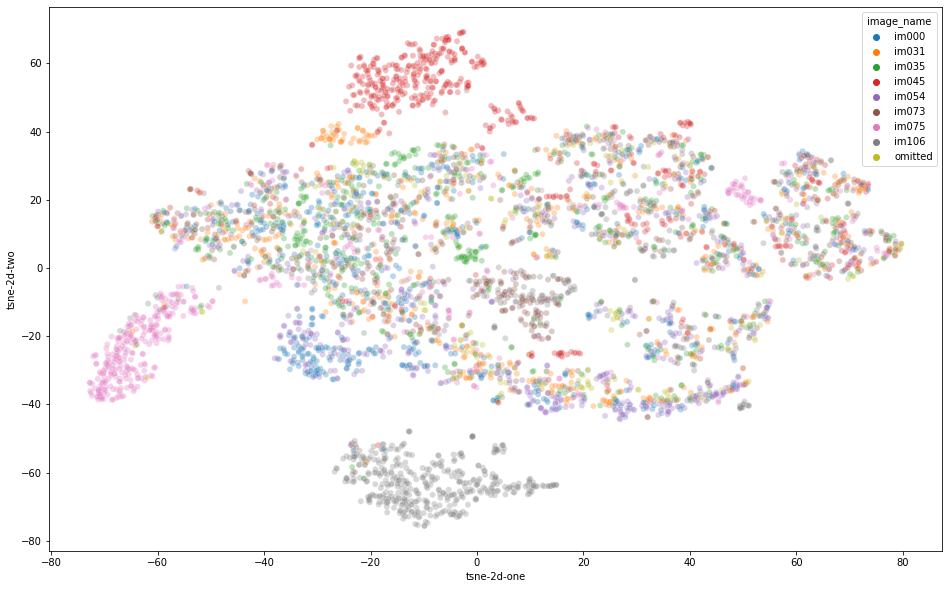

In [42]:
features_and_labels['tsne-2d-one'] = X_embedded[:,0]
features_and_labels['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    data=features_and_labels,
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="image_name",
    hue_order = np.sort(features_and_labels['image_name'].unique()),
    palette='tab10',
    legend="full",
    alpha=0.3
)

This demonstrates that the time-averaged population responses to at least some of the stimuli seem to fall into distinct clusters in our higher dimensional space, while others appear more overlapped. This implies that a decoding analysis might be more successful at decoding some stimuli than others.

## Train Linear Discriminant Analysis decoder
We can use an Linear Discriminant Analysis decoder from scikit learn to ask how well we can decode image identity from the feature matrix we have constructed. 

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, accuracy_score

Split our data into train and test sets, instantiate the model, then fit.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = LDA(store_covariance=True)
model.fit(X_train, y_train);

Use the model to make predictions on the held-out test set

In [48]:
y_pred = model.predict(X_test)
y_pred

array(['im035', 'im073', 'im073', ..., 'im031', 'im073', 'im045'],
      dtype='<U7')

Evaluate the accuracy

In [49]:
accuracy_score(y_test, y_pred)

0.7912988650693569

We can construct a confusion matrix as follows. Note that we are converting the matrix to a dataframe just to make axis labeling easier.

In [52]:
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred, normalize = True), 
    columns = ['predicted_{}'.format(im) for im in model.classes_],
    index = ['actual_{}'.format(im) for im in model.classes_]
)
confusion_df

,predicted_im000,predicted_im031,predicted_im035,predicted_im045,predicted_im054,predicted_im073,predicted_im075,predicted_im106,predicted_omitted
actual_im000,145,6,5,0,1,36,0,0,4
actual_im031,5,137,7,0,0,23,0,0,10
actual_im035,8,4,143,1,1,14,0,1,6
actual_im045,0,21,3,168,0,9,0,0,0
actual_im054,13,5,9,0,140,17,1,0,1
actual_im073,9,13,4,0,0,146,0,0,4
actual_im075,3,10,5,0,0,26,148,0,2
actual_im106,1,2,5,0,0,22,0,186,3
actual_omitted,2,2,2,0,0,5,0,0,42


In [58]:
# if above normalization step doesnt work:
# confusion_df = confusion_df/confusion_df.sum()

And we can also visualize our confusion matrix:

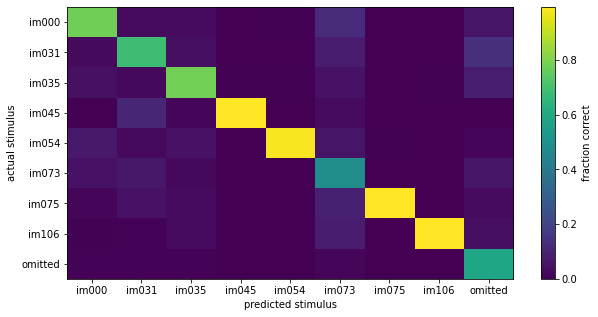

In [64]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(confusion_df, aspect='auto')

ax.set_xticks(np.arange(0,9))
ax.set_xticklabels(model.classes_)
ax.set_xlabel('predicted stimulus')

ax.set_yticks(np.arange(0,9))
ax.set_yticklabels(model.classes_)
ax.set_ylabel('actual stimulus')

plt.colorbar(im, label='fraction correct')

## we can plot the feature matrix after sorting by image ID
This helps explain how the classifier might be working: some cells are very image selective.

Text(0.5, 1.0, 'average responses sorted by image index')

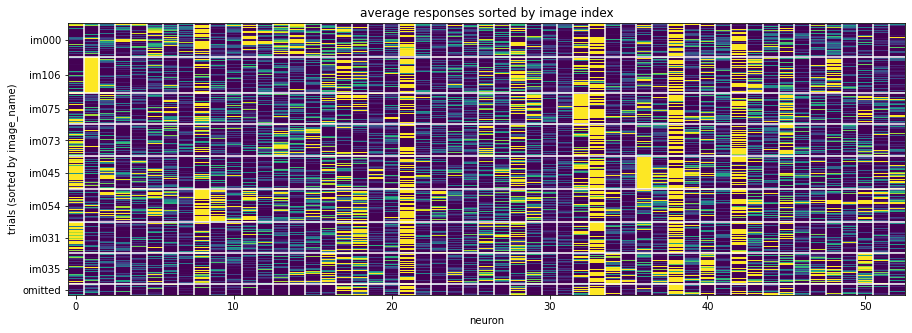

In [65]:
fig, ax = plt.subplots(figsize = (15,5))

sorted_matrix = features_and_labels.sort_values(by='image_index')
ax.imshow(sorted_matrix[cell_specimen_ids], aspect='auto', clim=[0,0.1], interpolation='none')

# add a white line to demarcate every distinct image
demarcations = []
sorted_matrix['last_image_index'] = sorted_matrix['image_index'].shift()
for idx, row in sorted_matrix.reset_index().iterrows():
    if row['last_image_index'] != row['image_index']:
        ax.axhline(idx, color='white')
        demarcations.append(idx)
demarcations.append(idx)

# set yticks at the halfway points between demarcations
ax.set_yticks([(demarcations[i] + demarcations[i+1])/2 for i in range(len(demarcations)-1)])      
# assign yticklabels as image_name
ax.set_yticklabels(sorted_matrix['image_name'].unique())

ax.set_ylabel('trials (sorted by image_name)')
ax.set_xlabel('neuron')

for i in range(0, len(cell_specimen_ids), 1):
    ax.axvline(i-0.5, color='white')


ax.set_title('average responses sorted by image index')

## And here are the images that the mouse saw.

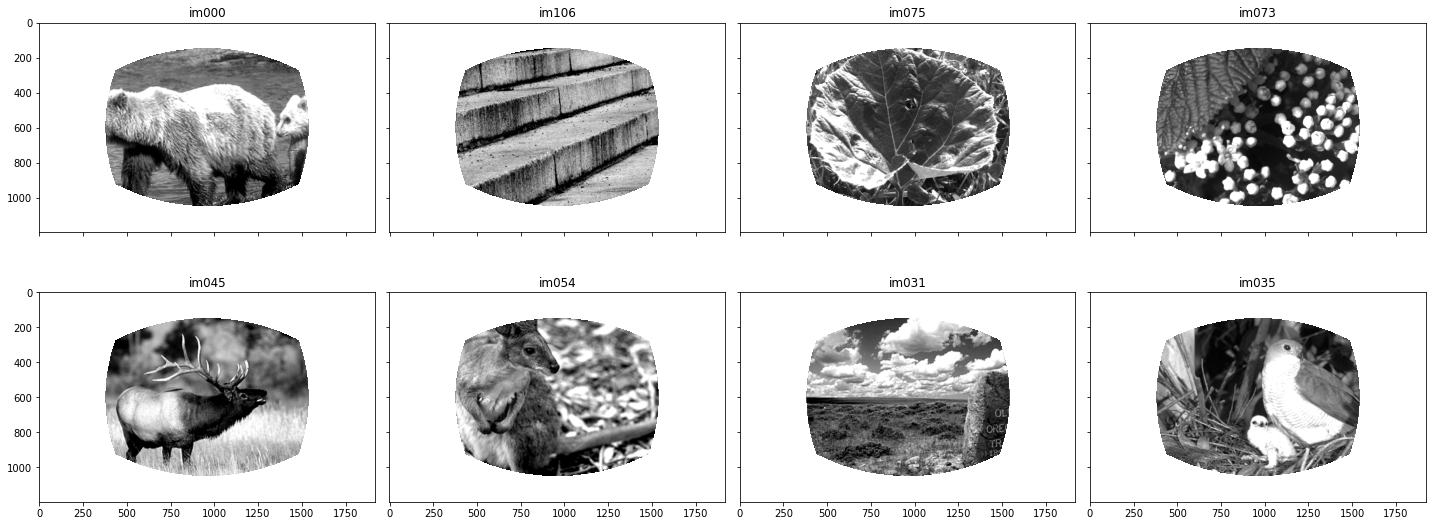

In [66]:
experiment = experiments[ophys_experiment_ids[0]]
fig, ax = plt.subplots(2,4,figsize = (20,8), sharex = True, sharey=True)
for ii,image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()